In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

In [2]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

train_set=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
test_set=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

trainloader=torch.utils.data.DataLoader(train_set,batch_size=128,shuffle=True,num_workers=2)
testloader=torch.utils.data.DataLoader(test_set,batch_size=128,shuffle=False,num_workers=2)

170499072it [01:14, 2303591.46it/s]                               


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))


In [5]:
device=torch.device("cuda" if torch.cuda.is_available else "cpu")
model.to(device)

loss_fn=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

In [6]:
from torchsummary import summary
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7          [-1, 128, 16, 16]          73,856
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,584
             ReLU-10          [-1, 128, 16, 16]               0
        MaxPool2d-11            [-1, 128, 8, 8]               0
      BatchNorm2d-12            [-1, 128, 8, 8]             256
           Conv2d-13            [-1, 256, 8, 8]         295,168
             ReLU-14            [-1, 25

In [7]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
count_parameters(model)

5852234

In [9]:
train_losses=[]
train_accu=[]

def train(epoch):
  print('\nEpoch : %d'%epoch)
  
  model.train()

  running_loss=0
  correct=0
  total=0

  for data in tqdm(trainloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  train_loss=running_loss/len(trainloader)
  accu=100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

In [10]:
eval_losses=[]
eval_accu=[]

def test(epoch):
  model.eval()

  running_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(testloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      running_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  test_loss=running_loss/len(testloader)
  accu=100.*correct/total

  eval_losses.append(test_loss)
  eval_accu.append(accu)

  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 



In [11]:
epochs=10
for epoch in range(1,epochs+1): 
  train(epoch)
  test(epoch)


Epoch : 1


100%|██████████| 391/391 [00:59<00:00,  6.56it/s]


Train Loss: 1.639 | Accuracy: 41.956


100%|██████████| 79/79 [00:06<00:00, 12.46it/s]


Test Loss: 1.247 | Accuracy: 54.990

Epoch : 2


100%|██████████| 391/391 [00:55<00:00,  6.99it/s]


Train Loss: 1.029 | Accuracy: 63.300


100%|██████████| 79/79 [00:06<00:00, 11.48it/s]


Test Loss: 0.913 | Accuracy: 67.840

Epoch : 3


100%|██████████| 391/391 [01:08<00:00,  5.71it/s]


Train Loss: 0.786 | Accuracy: 72.146


100%|██████████| 79/79 [00:07<00:00, 11.25it/s]


Test Loss: 0.800 | Accuracy: 71.910

Epoch : 4


100%|██████████| 391/391 [01:09<00:00,  5.61it/s]


Train Loss: 0.627 | Accuracy: 78.204


100%|██████████| 79/79 [00:07<00:00, 11.24it/s]


Test Loss: 0.721 | Accuracy: 74.670

Epoch : 5


100%|██████████| 391/391 [01:11<00:00,  5.49it/s]


Train Loss: 0.501 | Accuracy: 82.732


100%|██████████| 79/79 [00:06<00:00, 11.58it/s]


Test Loss: 0.706 | Accuracy: 75.540

Epoch : 6


100%|██████████| 391/391 [01:14<00:00,  5.27it/s]


Train Loss: 0.380 | Accuracy: 87.448


100%|██████████| 79/79 [00:06<00:00, 11.42it/s]


Test Loss: 0.674 | Accuracy: 76.910

Epoch : 7


100%|██████████| 391/391 [01:17<00:00,  5.04it/s]


Train Loss: 0.265 | Accuracy: 91.900


100%|██████████| 79/79 [00:07<00:00, 10.95it/s]


Test Loss: 0.693 | Accuracy: 77.340

Epoch : 8


100%|██████████| 391/391 [01:18<00:00,  4.95it/s]


Train Loss: 0.158 | Accuracy: 95.752


100%|██████████| 79/79 [00:06<00:00, 11.29it/s]


Test Loss: 0.744 | Accuracy: 76.800

Epoch : 9


100%|██████████| 391/391 [01:17<00:00,  5.04it/s]


Train Loss: 0.075 | Accuracy: 98.568


100%|██████████| 79/79 [00:07<00:00, 10.82it/s]


Test Loss: 0.735 | Accuracy: 78.050

Epoch : 10


100%|██████████| 391/391 [01:22<00:00,  4.75it/s]


Train Loss: 0.029 | Accuracy: 99.792


100%|██████████| 79/79 [00:07<00:00, 10.76it/s]

Test Loss: 0.773 | Accuracy: 78.660


In [12]:
#plot accuracy

plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

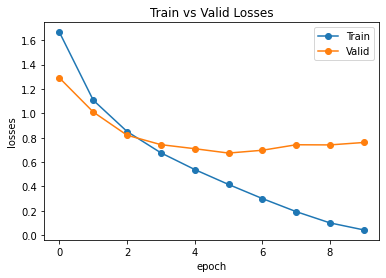

In [15]:
#plot losses

plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()